In [7]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import PySimpleGUI as sg 
import easygui

In [8]:
def pinta_laberinto(laberinto, matriz, mostrar = False):

    if mostrar == False:
        
        clear_output(wait=True)
        plt.figure(figsize = (laberinto.shape[0]/2.5, laberinto.shape[1]/2.5))
        plt.imshow(laberinto, cmap='hot')
        plt.show()
        
    else:
        
        # Mostramos la cantidad de feromonas que tiene cada celda
        clear_output(wait=True)
        values = matriz

        # Limites para cuadrar el texto
        x_start = 0
        x_end = laberinto.shape[1]
        y_start = 0
        y_end = laberinto.shape[0]

        extent = [x_start, x_end, y_start, y_end]

        # Creamos el gráfico normal
        fig = plt.figure(figsize = (laberinto.shape[0]/2.5, laberinto.shape[1]/2.5))
        ax = fig.add_subplot(111)
        im = ax.imshow(laberinto, extent=extent, cmap='hot')

        # Añadimos el texto
        jump_x = (x_end - x_start) / (2.0 * laberinto.shape[1])
        jump_y = (y_end - y_start) / (2.0 * laberinto.shape[0])
        x_positions = np.linspace(start=x_start, stop=x_end, num=laberinto.shape[1], endpoint=False)
        y_positions = np.linspace(start=y_start, stop=y_end, num=laberinto.shape[0], endpoint=False)
        
        if laberinto.shape[0] < 70 and laberinto.shape[1] < 70 and laberinto.shape[0] == laberinto.shape[1]:
            tamaño_letra = 8
        else:
            tamaño_letra = 5
        
        for y_index, y in enumerate(reversed(y_positions)):
            for x_index, x in enumerate(x_positions):
                label = values[y_index, x_index]
                text_x = x + jump_x
                text_y = y + jump_y
                ax.text(text_x, text_y, label, color='black', ha='center', va='center', size=tamaño_letra)

        plt.show()
            
    # return()

In [9]:
def tamaño_laberinto():

    layout = [[sg.Text("¿Cómo quieres de alto el laberinto? \n \nPrueba con 50, por ejemplo")],    
              [sg.Input()],
              [sg.Button('Ok')] ]   
    sg.theme('Reddit')
    window = sg.Window('Selección de alto ', layout, finalize = True)
    window.BringToFront()
    event, alto = window.read()
    window.close()
        
    layout = [[sg.Text("¿Cómo quieres de ancho el laberinto? \n \nPrueba con 100, por ejemplo")],    
              [sg.Input()],
              [sg.Button('Ok')] ]    
    sg.theme('Reddit')
    window = sg.Window('Selección de ancho ', layout, finalize = True)
    window.BringToFront()
    event, ancho = window.read()
    window.close()
    
    try:
    
        alto = int(alto[0])
        ancho = int(ancho[0])
        
    except:
        
        print("Debes indicar un número para el tamaño")
        alto, ancho = tamaño_laberinto()
    
    return alto, ancho

In [10]:
def construye_laberinto(muro = 0, pasillo = 10, hormiguero = 5, comida = 7):

    '''
    Lo primero que debemos hacer es construir un entorno en el que podamos poder a prueba la colonia de hormigas
    Este punto es muy importante. La manera en la que construyamos el laberinto puede hacer que sea muy fácil de resolver (solo haya una solución)
    Queremos generar laberintos aleatorios que puedan tener entre 0 y N soluciones
    Por otro lado, el cómo hagamos los caminos puede derivar en "rotondas" (como en la solución de excel), o "plazas" (como está programado aquí)
    En estas rotondas o plazas será donde la hormiga tendrá más dificultad a la hora de orientarse
    
    Por otro lado, La relación entre la feromona inicial y la feromono depositada (en función a la distancia) debe estar en perfecto equilibrio o el enjambre no funcionará
    Prestad atención a que la cantidad de feromona inicial es muy distinta si el laberinto es cuadrado u horizontal. Hay que prestar mucha atención a este punto

    '''

    alto, ancho = tamaño_laberinto()
    laberinto = np.zeros((alto, ancho))
    
    # Construimos los caminos del laberinto
    for camino in range(int(round((alto * ancho)/ 5))):

        inicio_ok = False
        while inicio_ok == False:

            fila = np.random.randint(low = 1, high = alto-1, size = 1)
            columna = np.random.randint(low = 1, high = ancho -1, size = 1)

            if laberinto[fila, columna] == muro:
                inicio_ok = True
                
                if camino == 0:
                    laberinto[fila, columna] = hormiguero
                else:
                    laberinto[fila, columna] = pasillo

        # A partir de la posición inicial, comenzamos a "tirar muros"
        # Condiciones de parada: que llegue a un pasillo o al muro exterior    

        direccion = np.random.randint(low = 1, high = 4, size = 1)    
        stop = False
        pos_fila = fila
        pos_col = columna
        longitud = 0

        while stop == False:

            if direccion == 1: # subimos

                # Comprobamos que la nueva posición es un muro y que no está en los límites
                if (laberinto[pos_fila - 1, pos_col] == muro and (pos_fila - 1) != 0 and laberinto[pos_fila, pos_col +1] == muro and laberinto[pos_fila, pos_col -1] == muro and longitud < round(laberinto.shape[0]/4)):
                    laberinto[pos_fila - 1, pos_col] = pasillo
                    pos_fila = pos_fila - 1
                    longitud += 1                  
                else:
                    stop = True

            elif direccion == 2: # bajamos

                # Comprobamos que la nueva posición es un muro y que no está en los límites
                if (laberinto[pos_fila + 1, pos_col] == muro and (pos_fila + 1) != laberinto.shape[0]-1 and laberinto[pos_fila, pos_col +1] == muro and laberinto[pos_fila, pos_col -1] == muro and longitud < round(laberinto.shape[0]/4)):
                    laberinto[pos_fila + 1, pos_col] = pasillo
                    pos_fila = pos_fila + 1
                    longitud += 1       
                else:
                    stop = True

            elif direccion == 3: # vamos a la derecha

                # Comprobamos que la nueva posición es un muro y que no está en los límites
                if (laberinto[pos_fila, pos_col + 1] == muro and (pos_col + 1) != laberinto.shape[1]-1 and laberinto[pos_fila +1, pos_col] == muro and laberinto[pos_fila-1, pos_col] == muro and longitud < round(laberinto.shape[0]/4)):
                    laberinto[pos_fila, pos_col + 1] = pasillo
                    pos_col = pos_col + 1
                    longitud += 1    
                else:
                    stop = True

            else: # vamos a la izquierda

                # Comprobamos que la nueva posición es un muro y que no está en los límites
                if (laberinto[pos_fila, pos_col - 1] == muro and (pos_col - 1) != 0 and laberinto[pos_fila +1, pos_col] == muro and laberinto[pos_fila-1, pos_col] == muro and longitud < round(laberinto.shape[0]/4)):
                    laberinto[pos_fila, pos_col - 1] = pasillo
                    pos_col = pos_col - 1
                    longitud += 1      
                else:
                    stop = True
    
    # La última posición será la comida
    laberinto[fila, columna] = comida
       
    # La relación entre la feromona inicial y la feromono depositada (en función a la distancia) debe estar en perfecto equilibrio o el enjambre no funcionará
    feromona_inicial = 1

    # Depositamos la feromona inicial en todas las casillas que no sean muros
    matriz_feromonas = np.zeros((laberinto.shape[0], laberinto.shape[1]))
    matriz_feromonas[laberinto != muro] = feromona_inicial
    
    # Depositamos una feromona muy alta en la comida, para que si pasan a su lado, la vean.
    matriz_feromonas[laberinto == comida] = feromona_inicial*1000
    
    # Por último, pintamos el laberinto terminado
    pinta_laberinto(laberinto, matriz= matriz_feromonas, mostrar = False)
    
    # Creamos una matriz_fiel para la hormiga fiel
    matriz_fiel = np.copy(laberinto)
    matriz_fiel[laberinto == muro] = 1000
    matriz_fiel[laberinto == pasillo] = 1000
    matriz_fiel[laberinto == hormiguero] = 1000
    matriz_fiel[laberinto == comida] = 0
    
    return laberinto, matriz_feromonas, matriz_fiel

In [11]:
class ant:
    
    def __init__(self ,laberinto, hormiguero):
        
        self.lista_movimientos = list()
        self.lista_movimientos.append(XXXXXX) # Las hormigas deben empezar en el hormiguero
            
    def moverse(self, laberinto, matriz_feromonas, matriz_fiel, muro = 0, pasillo = 10, hormiguero = 5, comida = 7, hormiga = 2):              
        
        # Debemos anular la opción de que retroceda por donde ha venido.  
        mov_posibles = np.copy(matriz_feromonas)
        
        if len(self.lista_movimientos) > 1:
            mov_posibles[self.lista_movimientos[-2][0],self.lista_movimientos[-2][1]] = 0    

        # La hormiga mira alrededor para determinar cuantas opciones de camino tiene
        subir = XXXXXX
        bajar = XXXXXX
        izq = XXXXXX
        der = XXXXXX

        # Debemos comprobar cuantas opciones de movimiento tiene. Si no tiene ninguna, debe retroceder y "anular" la casilla.
        if subir + bajar + izq + der == 0:
            
            if laberinto[self.lista_movimientos[-1][0],self.lista_movimientos[-1][1]] != hormiguero: 
                                    
                # Retrocedemos una posición y anulamos la casilla, para que ninguna otra hormiga la pise
                matriz_feromonas[XXXXXXX] = XXXXXXXX
                laberinto[XXXXXXX] = XXXXXXX         
                del self.lista_movimientos[-1]
                
            else:
                
                # Si no la reiniciamos, se queda bloqueada en el hormiguero.
                self.lista_movimientos = list()
                self.lista_movimientos.append(np.array(np.where(laberinto == hormiguero))[:,0])

        else: 

            # Decidimos movimiento "aleatoriamente" en función de las feromonas
            # Comparamos el número aleatorio con la distribución actual de feromonas por cada casilla. El intervalo en el que esté el número aleatorio será la dirección que elegirá.
            # Ej con tres posibles caminos a=20% , b=50%, c=30%, si el número aleatorio sale 75% --> 75>20 (no lo elije), 75>20+50 (no lo elije), 75<(20+50+30) (lo elije)
            feromona_total = subir + bajar + izq + der

            subir = subir / feromona_total
            bajar = bajar / feromona_total
            izq = izq / feromona_total
            der = der / feromona_total

            posibilidades = np.array([subir, bajar, izq, der])
            prox_mov = np.random.rand()

            for pos in range(len(posibilidades)):            
                if prox_mov < sum(posibilidades[0:pos+1]):        
                    break

            if pos == 0: # Subimos
                self.lista_movimientos.append(np.array([self.lista_movimientos[-1][0]-1, self.lista_movimientos[-1][1]]))
            elif pos == 1: # Bajamos
                self.lista_movimientos.append(np.array([self.lista_movimientos[-1][0]+1, self.lista_movimientos[-1][1]]))
            elif pos == 2: # Izquierda
                self.lista_movimientos.append(XXXXXXX)
            else: # Derecha
                self.lista_movimientos.append(XXXXXXXXX)
        
        # Mostramos el movimiento
        self.mostrar_movimiento(laberinto)   
        
    def mostrar_movimiento(self, laberinto):
        
        # Mostramos el movimiento visualmente (debemos comprobar que no es el hormiguero ni la comida)
        if laberinto[self.lista_movimientos[-1][0],self.lista_movimientos[-1][1]] == pasillo:
            laberinto[self.lista_movimientos[-1][0],self.lista_movimientos[-1][1]] = XXXXXXX

        # Borramos el movimiento anterior (volviendo a ser un pasillo)
        if len(self.lista_movimientos) > 1:
            if laberinto[self.lista_movimientos[-2][0],self.lista_movimientos[-2][1]] == XXXXXXX:
                laberinto[self.lista_movimientos[-2][0],self.lista_movimientos[-2][1]] = XXXXXXX
    
        

## Ejecutamos el programa

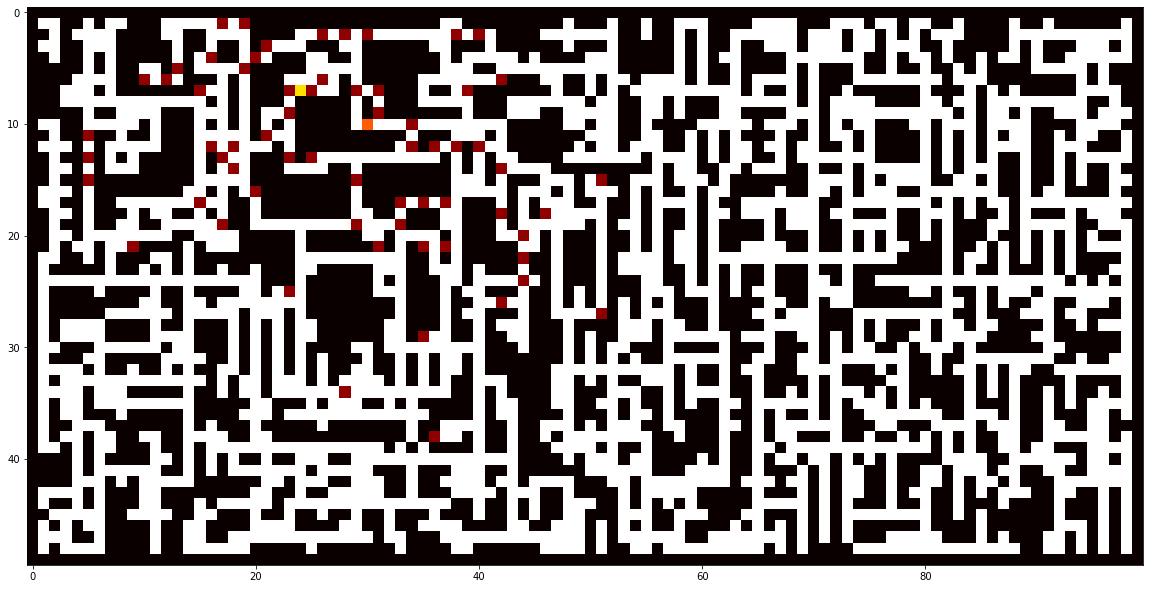

In [12]:
muro = 0
pasillo = 10
hormiguero = 5
comida = 7
hormiga = 2

# Construimos el laberinto y depositamos las feromonas iniciales
laberinto, matriz_feromonas, matriz_fiel = construye_laberinto(muro = muro, pasillo = pasillo, hormiguero = hormiguero, comida = comida)

# El número de hormigas dependerá del tamaño del laberinto
n_hormigas = int(round((sum(laberinto.shape)/2)))
lista_hormigas = XXXXXXX # Instanciamos las hormigas

# Comprobamos movimientos
iteraciones = 0
while iteraciones < 50: 

    iteraciones += 1
    if iteraciones > laberinto.shape[0]*laberinto.shape[1] and veces_comida_encontrada == 0:
        easygui.msgbox("""Este laberinto no tiene solución.\n \n 
        Cuando el laberinto es muy pequeño esto puede pasar.\n \n
        Prueba con uno más grande.\n \n
        Si el que has instanciado ya era grande, símplemente, inténtalo de nuevo""", title="Conclusión") 
        break

    for ele in lista_hormigas: 
        ele.moverse(laberinto, matriz_feromonas, matriz_fiel)

    pinta_laberinto(laberinto, matriz= matriz_feromonas, mostrar = False)
    